In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py as h5
import healpy as hp
import os

#mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')
mpl.rcParams['font.size'] = 20

In [2]:
#making 2 sample localization plots with files from chime cat 1
f1 = h5.File('catalog/FRB20190128C_localization.h5','r')
#f2 = h5.File('catalog/FRB20190517C_localization.h5','r')
#f3 = h5.File('catalog/FRB20190320E_localization.h5','r')

#copied directly from https://chime-frb-open-data.github.io/localization.html
# The following function just summarizes the HDF5 file structure:
def describe(group, recurse=False):
    """ Prints info on the contents of an hdf5 group """

    print(group.name)

    # First print header-like attributes (if exist)
    if group.attrs:
        print('\n  attrs: {')
    for key, value in group.attrs.items():
        if key in ['comments', 'history']:
            print('    %s:' % key)
            for line in value:
                print('      ' + str(line))
        else:
            print('    %s:' % key, value)
    if group.attrs:
        print('  }')

    # Then print constituent groups & datasets
    print()
    for key, value in group.items():
        if isinstance(value, h5.Group):
            if recurse:
                print('-'*60)
                describe(value, True)
            else:
                print('  ' + key + '/')
        else:
            print('  ' + key + ':', value.shape, value.dtype)
    print()
describe(f1['/'])

/

  attrs: {
    tns_name: FRB20190128C
    ra: 69.8
    ra_hms: 4h39m12s
    ra_error: 0.231
    dec: 78.94
    dec_dms: 78d56m24s
    dec_error: 0.381
    glon: 132.83243017827948
    glat: 20.75536319983523
    frame: ICRS
    epoch: J2000
    units: degrees
    comments:
      Reported errors are at the 68% CL.
      R.A. errors have been scaled by cos(dec).
      Regions reported here are for the mainlobe island.
      See further data products for sidelobe islands.
  }

  healpix/
  projection/
  contours/



In [5]:
dat_loc='/data/user/jthwaites/chime_localization_data/'
dat_files=os.listdir(dat_loc)

FRB20180907D_localization.h5 350.66266 247.88994


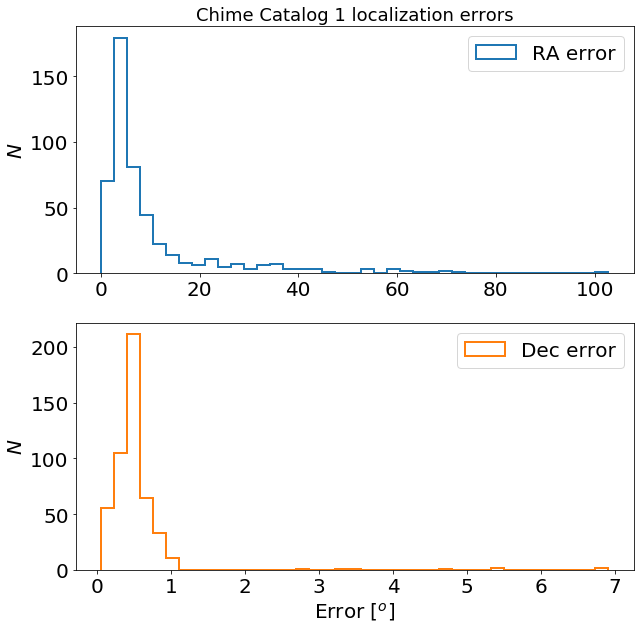

In [12]:
new_localizations={'tns_name':[],'ra_unc':[],'dec_unc':[]}
for file in dat_files:
    f = h5.File(dat_loc+file,'r')
    
    ra_loc=f['/'].attrs['ra_error']
    dec_loc=f['/'].attrs['dec_error']

    extent=[[0,361],[0,91]]
    for name, contour in f['/contours/68/'].items():
        contour=contour[:]
        max_ra=max(contour[0])
        if max_ra> extent[0][0]: extent[0][0]=max_ra
        min_ra=min(contour[0])
        if min_ra< extent[0][1]: extent[0][1]=min_ra
        max_dec=max(contour[1])
        if max_dec> extent[1][0]: extent[1][0]=max_dec
        min_dec=min(contour[1])
        if min_dec < extent[1][1]: extent[1][1]=min_dec
    
    if (extent[0][0]-extent[0][1]) > ra_loc: ra_loc=extent[0][0]-extent[0][1]
    if (extent[1][0]-extent[1][1]) > dec_loc: dec_loc=extent[1][0]-extent[1][1]
    
    new_localizations['tns_name'].append(f['/'].attrs['tns_name'])
    new_localizations['ra_unc'].append(ra_loc)
    new_localizations['dec_unc'].append(dec_loc)

dec_bins=np.linspace(min(new_localizations['dec_unc']),
                     max(new_localizations['dec_unc']), num=40)
ra_bins=np.linspace(min(new_localizations['ra_unc']),
                     max(new_localizations['ra_unc']), num=40)

fig, ax = plt.subplots(2,figsize=(10,10))
ax[0].hist(new_localizations['ra_unc'], bins=ra_bins, histtype='step', 
         lw=2., label='RA error', color='C0')
ax[1].hist(new_localizations['dec_unc'], bins=dec_bins, histtype='step', 
         lw=2., label='Dec error', color='C1')

ax[0].set_ylabel(r'$N$')
ax[1].set_ylabel(r'$N$')
ax[1].set_xlabel(r'Error [$^o$]')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[0].set_title(r'Chime Catalog 1 localization errors', fontsize=18)
plt.savefig('./frb_param_plots/cat1_loc_err_new.png')

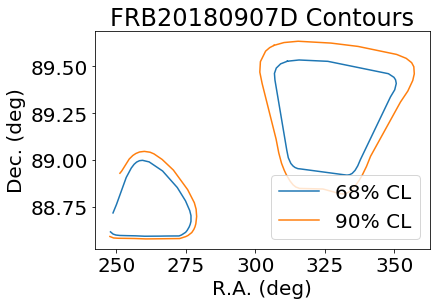

In [15]:
f1 = h5.File(dat_loc+'FRB20180907D_localization.h5','r')
def show_contours(f):
    i=0
    for name, contour in f['/contours/68/'].items():
        contour=contour[:]
        if i==0: plt.plot(contour[0],contour[1],color='C0', label='68% CL')
        else: plt.plot(contour[0],contour[1],color='C0')
        i+=1
    i=0
    for name, contour in f['/contours/90/'].items():
        contour=contour[:]
        if i==0: plt.plot(contour[0],contour[1],color='C1', label='90% CL')
        else: plt.plot(contour[0],contour[1],color='C1')
        i+=1
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    plt.legend(loc=4)
    plt.title('%s Contours'%f['/'].attrs['tns_name'])
    plt.show()
show_contours(f1)

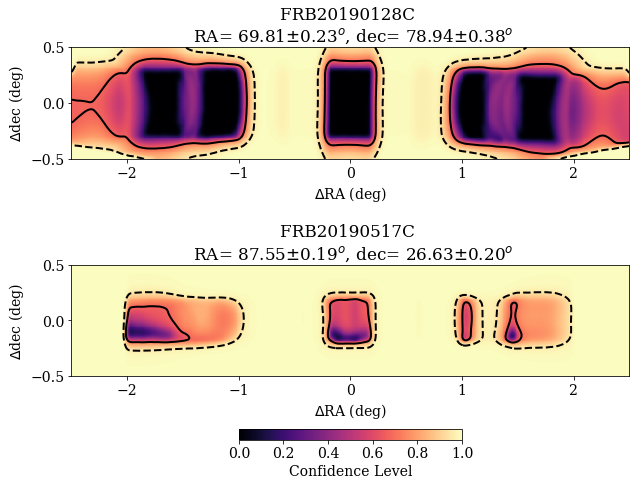

In [5]:
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(2, 1, figsize=(10,8.5))

# Note: RA increases to the left!
hdr = f1['projection'].attrs
CL = f1['projection/data'][:]
extent = np.array([-hdr['xsize']/2, hdr['xsize']/2, 
                    -hdr['ysize']/2, hdr['ysize']/2])*hdr['reso']/60

im = ax[0].imshow(CL, vmin=0, origin='lower',
                extent=extent, cmap='magma')
ax[0].contour(CL, levels=[0.68, 0.95], linestyles=['-', '--'], 
            colors='k', linewidths=2, extent=extent)
ax[0].set_title('%s \n RA= %.2f$\pm$%.2f$^o$, dec= %.2f$\pm$%.2f$^o$' %(f1.attrs['tns_name'],hdr['clon'], 
                                               f1.attrs['ra_error'], hdr['clat'], f1.attrs['dec_error']))
ax[0].set_xlabel('$\Delta$RA (deg)')
ax[0].set_ylabel('$\Delta$dec (deg)')

hdr = f2['projection'].attrs
CL = f2['projection/data'][:]
extent = np.array([-hdr['xsize']/2, hdr['xsize']/2, 
                    -hdr['ysize']/2, hdr['ysize']/2])*hdr['reso']/60

im = ax[1].imshow(CL, vmin=0, origin='lower',
                extent=extent, cmap='magma')
ax[1].contour(CL, levels=[0.68, 0.95], linestyles=['-', '--'], 
            colors='k', linewidths=2, extent=extent)

ax[1].set_title('%s \n RA= %.2f$\pm$%.2f$^o$, dec= %.2f$\pm$%.2f$^o$' %(f2.attrs['tns_name'],hdr['clon'], 
                                               f2.attrs['ra_error'], hdr['clat'], f2.attrs['dec_error']))
ax[1].set_xlabel('$\Delta$RA (deg)')
ax[1].set_ylabel('$\Delta$dec (deg)')

plt.colorbar(im, pad=0.25, shrink=0.4, orientation='horizontal',
                label='Confidence Level')

plt.savefig('./frb_param_plots/sample1_locpdfs.png')

In [18]:
# https://github.com/icecube/FastResponseAnalysis/blob/1ef71ea017805e7180f2b616796ba5474284aa88/fast_response/FastResponseAnalysis.py#L1218
# Other functions here have things that add axis labels and such

def plot_zoom(scan, ra, dec, title='', reso=3, var="pVal", range=[0, 6],cmap='Blues'):
    if cmap is None:
        pdf_palette = sns.color_palette("Blues", 500)
        cmap = mpl.colors.ListedColormap(pdf_palette)
    hp.gnomview(scan, rot=(np.degrees(ra), np.degrees(dec), 0),
                    cmap=cmap,
                    max=max(scan),
                    reso=reso,
                    title=title,
                    notext=True,
                    cbar=False,
                    nest=False
                    #unit=r""
                    )

    plt.plot(4.95/3.*reso*np.radians([-1, 1, 1, -1, -1]), 4.95/3.*reso*np.radians([1, 1, -1, -1, 1]), color="k", ls="-", lw=3)
    hp.graticule(verbose=False)
    plot_labels(dec, ra, reso)
    
def plot_labels(src_dec, src_ra, reso):
    """Add labels to healpy zoom"""
    fontsize = 20
    plt.text(-1*np.radians(1.75*reso),np.radians(0), r"%.2f$^{\circ}$"%(np.degrees(src_dec)),
             horizontalalignment='right',
             verticalalignment='center', fontsize=fontsize)
    plt.text(-1*np.radians(1.75*reso),np.radians(reso), r"%.2f$^{\circ}$"%(reso+np.degrees(src_dec)),
             horizontalalignment='right',
             verticalalignment='center', fontsize=fontsize)
    plt.text(-1*np.radians(1.75*reso),np.radians(-reso), r"%.2f$^{\circ}$"%(-reso+np.degrees(src_dec)),
             horizontalalignment='right',
             verticalalignment='center', fontsize=fontsize)
    plt.text(np.radians(0),np.radians(-1.75*reso), r"%.2f$^{\circ}$"%(np.degrees(src_ra)),
             horizontalalignment='center',
             verticalalignment='top', fontsize=fontsize)
    plt.text(np.radians(reso),np.radians(-1.75*reso), r"%.2f$^{\circ}$"%(-reso+np.degrees(src_ra)),
             horizontalalignment='center',
             verticalalignment='top', fontsize=fontsize)
    plt.text(np.radians(-reso),np.radians(-1.75*reso), r"%.2f$^{\circ}$"%(reso+np.degrees(src_ra)),
             horizontalalignment='center',
             verticalalignment='top', fontsize=fontsize)
    plt.text(-1*np.radians(2.35*reso), np.radians(0), r"declination", 
                ha='center', va='center', rotation=90, fontsize=fontsize)
    plt.text(np.radians(0), np.radians(-2.05*reso), r"right ascension", 
                ha='center', va='center', fontsize=fontsize)

In [88]:
frb = dat_loc + 'FRB20190517C_localization.h5'
f = h5.File(frb, 'r')

ra = np.radians(f['/'].attrs['ra'])
dec = np.radians(f['/'].attrs['dec'])

original_nside = f['healpix'].attrs['nside']
new_nside=512
ipix, CL = f['healpix/ipix'][()], f['healpix/CL'][()]
probs = (1. - CL)/ (1. - CL).sum()
frb_probs = np.zeros(hp.nside2npix(original_nside))
frb_probs[ipix] = probs
print(len(probs[np.where(probs!=0)[0]]))
print(len(probs))
print(len(frb_probs))
print(len(frb_probs[np.where(frb_probs!=0)[0]]))
frb_probs[np.where(frb_probs!=0)[0]]
u,c=np.unique(ipix, return_counts=True)
len(c)

146590
149817
201326592
11197


11463

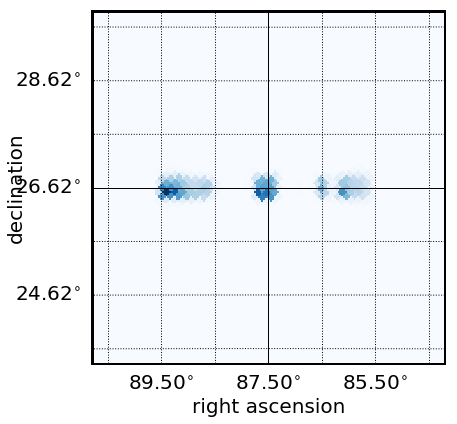

In [60]:
frb_probs = hp.ud_grade(frb_probs,
                new_nside, order_in='NESTED', order_out='RING')
plot_zoom(frb_probs, ra, dec, reso=2)

In [63]:
probs[np.where(CL <= .68)[0]].sum()
frb_probs.sum()

0.001190613043652807